### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pandas as pd

import dysts
import dysts.flows

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Run benchmark

This benchmark requires [torchdiffeq](https://github.com/rtqichen/torchdiffeq) to be installed, as well as [sktime](https://www.sktime.org/en/latest/index.html) for scoring

In [98]:
%%bash --out output --err error

python3 node_benchmarks.py

# Analyze results

Some optional plotting utilities use [seaborn](https://github.com/mwaskom/seaborn) and [degas](https://github.com/williamgilpin/degas)

In [163]:
cwd = os.getcwd()
output_path = cwd + "/results/results_neural_ode.json"

with open(output_path, "r") as file:
    all_results_dict = json.load(file)
all_results = pd.DataFrame(
    [(item, all_results_dict[item]["smape"]) for item in all_results_dict],
    columns=["name", "score"],
)
all_results.set_index("name", inplace=True)

## Collect annotations


attributes =  ['maximum_lyapunov_estimated', 'kaplan_yorke_dimension', 
               'multiscale_entropy', 'correlation_dimension']
all_properties = dict()
for equation_name in dysts.base.get_attractor_list():
    eq = getattr(dysts.flows, equation_name)()
    attr_vals = [getattr(eq, item, None) for item in attributes]
    all_properties[equation_name] = dict(zip(attributes, attr_vals))
all_properties = pd.DataFrame(all_properties).transpose().dropna()
all_properties.index.rename("name", inplace=True)
# all_properties


0.6502503741564871


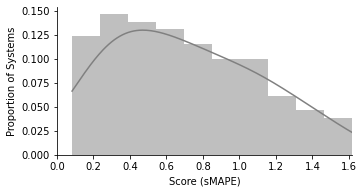

In [168]:
import seaborn as sns
import degas as dg
FIGURE_PATH = "../private_writing/figs/"

sns.displot(all_results, 
            x="score", 
            kde=True,
            stat="probability",
            color=(0.5, 0.5, 0.5),
            linewidth=0,
            bins=10,
            #clip=(0.0, np.nanpercentile(all_results["score"], 99.5)),
            #kde=True, cut=0,
            kde_kws={"bw_method" : 0.5}
           )
print(np.median(all_results["score"]))
plt.xlim([0, np.max(all_results["score"])])
plt.ylabel("Proportion of Systems")
plt.xlabel("Score (sMAPE)")
dg.fixed_aspect_ratio(1/2)
# dg.better_savefig(FIGURE_PATH + f"sfig_histogram_node.pdf")

maximum_lyapunov_estimated    0.071778
kaplan_yorke_dimension        0.014775
multiscale_entropy           -0.020521
correlation_dimension         0.007952
score                         1.000000
Name: score, dtype: float64
Errors:  [0.00303999 0.00313347 0.00299106 0.00312839 0.        ]


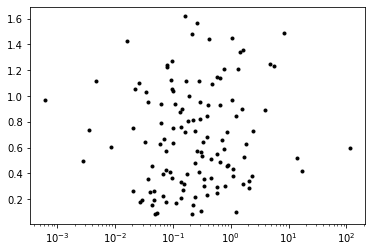

In [130]:
from scipy.stats import sem

df_full = all_properties.join(all_results)
print(df_full.corr(method="spearman").loc["score"])

## Bootstrap to estimate errors
all_corrs = list()
for i in range(1000):
    sel_inds = np.random.choice(np.arange(df_full.shape[0]), df_full.shape[0], replace=True)
    all_corrs.append((df_full.iloc[sel_inds]).corr(method="spearman").loc["score"])
print("Errors: ", sem(np.array(all_corrs), axis=0))

plt.semilogx(df_full["maximum_lyapunov_estimated"], df_full["score"], '.k')